# The Relationship between the Traffic Layout Mode and the Public Service Layout Mode of Manhattan <Junjie Cai, JunjieTsai, jc9033>
### PUI2018 Extra Credit Project

### This analysis is designed explore how the traffic layout mode relate to public service layout mode in Manhattan.

### Idea: 
The functional space of a city can be interpreted hierarchically as layers, with complex connections among them. These layers form a integrated urban space together. For example, the public service facilities make up a layer and the transportation facilities make up another layer, and this article is devoted to studying the connections between them. 

### Objective: 
study the mechanism of urban structure generation by relating the traffic layout mode to the public service layout mode.
	
### Quantitative indicators: 
the distribution of POI is used to indicate the public service layout mode; <br>
the distributions of bus stations and subway stations are used to indicate the traffic layout mode.
	
### Hypothesis: 
the public service layout mode is correlated with the traffic layout mode in Manhattan, NYC.



In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np

import io
import os
import requests
import shapely
import json
import urllib

import geopandas as gpd
from fiona.crs import from_epsg

import scipy as sp
from scipy import stats
from scipy import ndimage

import pylab as pl
import matplotlib.pylab as plt

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. process datasets

## 1.1 zipcode shpfie

In [2]:
url = "https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip"
urllib.request.urlretrieve(url, "zipcode_file.gz")
!mkdir $PUIDATA/zipcode
!unzip -o zipcode_file.gz -d $PUIDATA/zipcode

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/zipcode’: File exists
Archive:  zipcode_file.gz
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shx  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.dbf  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.prj  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.sbn  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.sbx  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shp  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shp.xml  


In [3]:
zipcode = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/zipcode/ZIP_CODE_040114.shp")
zipcode = zipcode[zipcode['COUNTY'] == 'New York']
zipcode = zipcode[['ZIPCODE', 'POPULATION', 'AREA', 'geometry']]
zipcode.crs = from_epsg(2263)
#zipcode.crs = from_epsg(4326)
#zipcode.crs = zipcode.to_crs(epsg=2263) 
print(zipcode.shape)
zipcode.head(3)

(112, 4)


,ZIPCODE,POPULATION,AREA,geometry
19,10463,70641.0,3.119702e+06,"POLYGON ((1007634.817063555 258290.334846884, ..."
21,10034,39149.0,2.450389e+07,"POLYGON ((1006203.169008225 257345.6566181332,..."
22,10033,54284.0,1.615605e+07,"POLYGON ((1003020.86467731 256049.1618358046, ..."


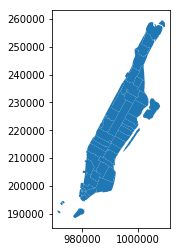

In [4]:
zipcode.plot()

## 1.2 POI shpfile

In [5]:
url = "https://data.cityofnewyork.us/api/geospatial/rxuy-2muj?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "POI_file.gz")
!mkdir $PUIDATA/POI
!unzip -d $PUIDATA/POI POI_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/POI’: File exists
Archive:  POI_file.gz
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_5abc45d9-039a-4e1e-a73f-1186d1df4556.dbf  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_5abc45d9-039a-4e1e-a73f-1186d1df4556.shp  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_5abc45d9-039a-4e1e-a73f-1186d1df4556.shx  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_5abc45d9-039a-4e1e-a73f-1186d1df4556.prj  


In [6]:
POI = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/POI/geo_export_87f05754-f29b-4dc2-a82d-5c9479f324f2.shp")
POI.crs = from_epsg(4326)
POI = POI.to_crs(epsg=2263)
POI = POI[['borough','geometry']]
POI.dropna(inplace=True)
POI['borough'] = POI['borough'].astype(int)
POI = POI[POI['borough'] == 1]
POI.columns = ['POI_borough','geometry']
print(POI.shape)
POI.head(3)

(5777, 2)


,POI_borough,geometry
22,1,POINT (989104.3522338871 226715.9110106869)
24,1,POINT (1002439.031799316 240947.530395451)
25,1,POINT (991170.0405883786 201159.453613225)


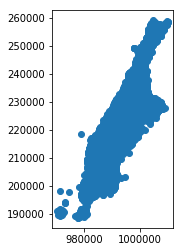

In [7]:
POI.plot()

## 1.3 Subway station shpfile

In [8]:
url = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "subway_file.gz")
!mkdir $PUIDATA/subway
!unzip -d $PUIDATA/subway subway_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/subway’: File exists
Archive:  subway_file.gz
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1bfae396-31df-476c-afd9-5a89e8c6c4ea.dbf  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1bfae396-31df-476c-afd9-5a89e8c6c4ea.shp  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1bfae396-31df-476c-afd9-5a89e8c6c4ea.shx  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1bfae396-31df-476c-afd9-5a89e8c6c4ea.prj  


In [9]:
subway = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/subway/geo_export_539576af-15f9-411d-9278-96f70d266f16.shp")
subway = subway[['geometry','objectid']]
subway.columns = ['geometry','subway_id']
subway.crs = from_epsg(4326)
subway = subway.to_crs(epsg=2263)
print(subway.shape)
subway.head(3)

(473, 2)


,geometry,subway_id
0,POINT (986725.0019278985 205255.0527942391),1.0
1,POINT (984196.5000951464 201155.8398640769),2.0
2,POINT (988724.2161053148 216795.1908031626),3.0


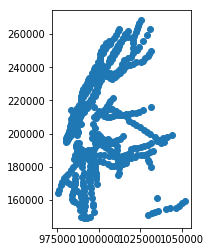

In [10]:
subway.plot()

In [11]:
subway = gpd.sjoin(subway, zipcode, how="inner")[['geometry', 'subway_id']]
print(subway.shape)
subway.head(3)

(152, 2)


,geometry,subway_id
0,POINT (986725.0019278985 205255.0527942391),1.0
104,POINT (987034.9461898913 206937.932958669),105.0
370,POINT (987039.020328727 202831.4349380784),371.0


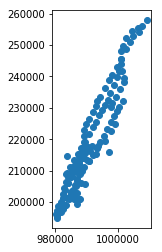

In [12]:
subway.plot()

## 1.4 Bus station shpfile

In [13]:
url = "https://data.cityofnewyork.us/api/geospatial/qafz-7myz?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "bus_file.gz")
!mkdir $PUIDATA/bus
!unzip -d $PUIDATA/bus bus_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/bus’: File exists
Archive:  bus_file.gz
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_7b6eea8c-16ac-476c-bb74-b7432e992f47.dbf  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_7b6eea8c-16ac-476c-bb74-b7432e992f47.shp  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_7b6eea8c-16ac-476c-bb74-b7432e992f47.shx  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_7b6eea8c-16ac-476c-bb74-b7432e992f47.prj  


In [14]:
bus = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/bus/geo_export_85792e91-7386-4102-9317-caa2249ff1eb.shp")
bus = bus[['asset_id', 'geometry']]
bus.columns = ['bus_id', 'geometry']
bus.crs = from_epsg(4326)
bus = bus.to_crs(epsg=2263)
print(bus.shape)
bus.head(3)

(3428, 2)


,bus_id,geometry
0,1.0,POINT (998713.9845957432 196791.4612668745)
1,2.0,POINT (999451.1694101784 201267.7107736471)
2,3.0,POINT (999282.6626072562 195394.2365739072)


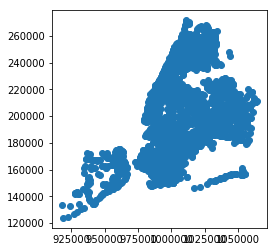

In [15]:
bus.plot()

In [16]:
bus = gpd.sjoin(bus, zipcode, how="inner")[['geometry', 'bus_id']]
print(bus.shape)
bus.head(3)

(755, 2)


,geometry,bus_id
903,POINT (987048.9820783393 207785.7335819595),904.0
1563,POINT (986159.9966711717 207305.0940948088),1564.0
1564,POINT (987714.2675982895 206518.31025707),1565.0


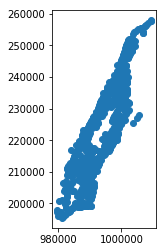

In [17]:
bus.plot()

## 1.5 Generate all traffic station points

In [18]:
TrafficStation = bus.drop('bus_id',axis=1).append(subway.drop('subway_id',axis=1)).reset_index().rename(columns={'index':'TrafficStation'})
print(TrafficStation.shape)
TrafficStation.head()

(907, 2)


,TrafficStation,geometry
0,903,POINT (987048.9820783393 207785.7335819595)
1,1563,POINT (986159.9966711717 207305.0940948088)
2,1564,POINT (987714.2675982895 206518.31025707)
3,1664,POINT (986602.7137353685 203035.5358111775)
4,1748,POINT (987327.1198019211 204183.6237035487)


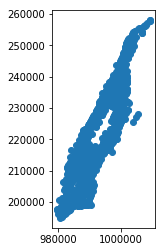

In [19]:
TrafficStation.plot()

In [20]:
!mv *.gz $PUIDATA

# 2. Sjoin

In [21]:
print(POI.shape)
print(subway.shape)
print(bus.shape)
print(zipcode.shape)

(5777, 2)
(152, 2)
(755, 2)
(112, 4)


In [22]:
sjoin_POI = gpd.sjoin(zipcode, POI, how="left")[['ZIPCODE','POI_borough']].groupby("ZIPCODE").count()
sjoin_POI = sjoin_POI.reset_index()
print(sjoin_POI.POI_borough.sum())
print(sjoin_POI.shape)
sjoin_POI.head()

5645
(106, 2)


,ZIPCODE,POI_borough
0,00083,213
1,10001,118
2,10002,297
3,10003,205
4,10004,70


In [23]:
sjoin_subway = gpd.sjoin(zipcode, subway, how="left")[['ZIPCODE','subway_id']].groupby("ZIPCODE").count()
sjoin_subway = sjoin_subway.reset_index()
print(sjoin_subway.subway_id.sum())
print(sjoin_subway.shape)
sjoin_subway.head()

152
(106, 2)


,ZIPCODE,subway_id
0,00083,6
1,10001,7
2,10002,5
3,10003,7
4,10004,3


In [24]:
sjoin_bus = gpd.sjoin(zipcode, bus, how="left")[['ZIPCODE','bus_id']].groupby("ZIPCODE").count()
sjoin_bus = sjoin_bus.reset_index()
print(sjoin_bus.bus_id.sum())
print(sjoin_bus.shape)
sjoin_bus.head()

759
(106, 2)


,ZIPCODE,bus_id
0,00083,0
1,10001,19
2,10002,33
3,10003,15
4,10004,3


In [25]:
zipcode = pd.merge(zipcode, sjoin_POI, on='ZIPCODE')
zipcode = pd.merge(zipcode, sjoin_subway, on='ZIPCODE')
zipcode = pd.merge(zipcode, sjoin_bus, on='ZIPCODE')

zipcode.rename(columns={'POI_borough':'POI', 'subway_id': 'subway', 'bus_id':'bus'}, inplace=True)

zipcode['TrafficStation'] = zipcode['subway'] + zipcode['bus']
zipcode.head()

,ZIPCODE,POPULATION,AREA,geometry,POI,subway,bus,TrafficStation
0,10463,70641.0,3.119702e+06,"POLYGON ((1007634.817063555 258290.334846884, ...",15,1,3,4
1,10034,39149.0,2.450389e+07,"POLYGON ((1006203.169008225 257345.6566181332,...",117,3,15,18
2,10033,54284.0,1.615605e+07,"POLYGON ((1003020.86467731 256049.1618358046, ...",88,3,15,18
3,10040,41033.0,1.634074e+07,"POLYGON ((1002564.135275811 253724.7731118798,...",100,4,16,20
4,10032,57606.0,2.315957e+07,"POLYGON ((998935.8528342247 249154.259943217, ...",149,5,35,40


# 3. Choropleth maps

(969193.1559385045, 1011861.583035858, 184889.21821436362, 263166.540957316)

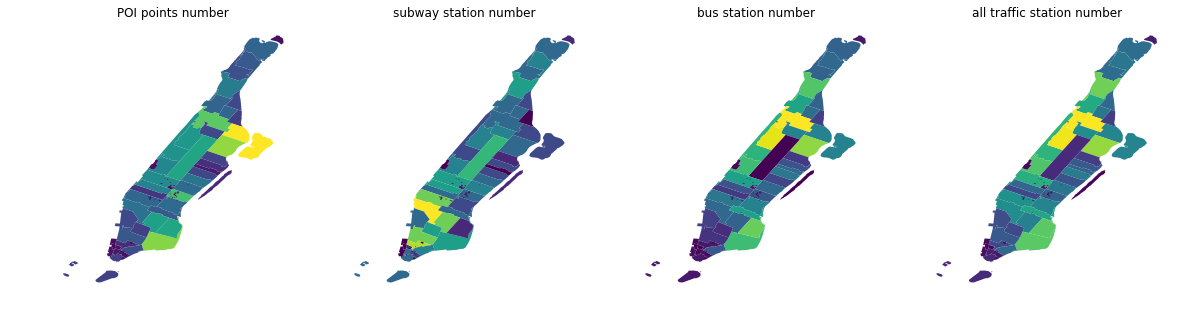

In [26]:
fig = pl.figure(figsize=(20,5))

ax1 = fig.add_subplot(141)
zipcode.plot(column='POI', ax=ax1, label=True)
ax1.set_title("POI points number")
ax1.axis('off')

ax2 = fig.add_subplot(142)
zipcode.plot(column='subway', ax=ax2, label=True)
ax2.set_title("subway station number")
ax2.axis('off')

ax3 = fig.add_subplot(143)
zipcode.plot(column='bus', ax=ax3, label=True)
ax3.set_title("bus station number")
ax3.axis('off')

ax4 = fig.add_subplot(144)
zipcode.plot(column='TrafficStation', ax=ax4, label=True)
ax4.set_title("all traffic station number")
ax4.axis('off')

**Figure 1** distribution of POI points number, subway station number, bus station number, and all traffic station number by zipcode area.<br>
**The choropleth maps cannot show the aggregation density of the points clearly. Thus I will plot heatmap of the points.**

# 4. Heatmaps

In [27]:
# refer to http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
        
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

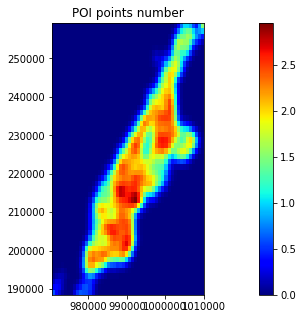

In [28]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("POI points number")
heatmap(POI, bins=50, smoothing=1)

**Figure 2-1** Headmap of POI points

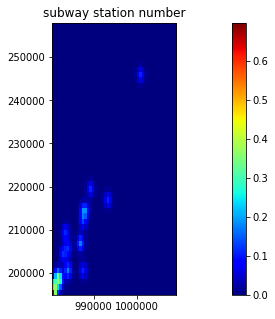

In [29]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("subway station number")
heatmap(subway, bins=50, smoothing=1)

**Figure 2-2** Headmap of subway station points

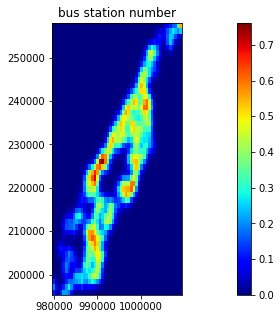

In [30]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("bus station number")
heatmap(bus, bins=50, smoothing=1)

**Figure 2-1** Headmap of bus station points

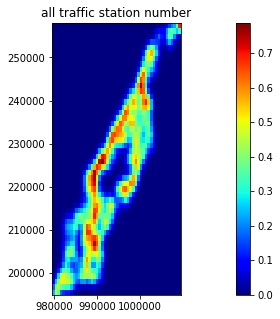

In [31]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("all traffic station number")
heatmap(TrafficStation, bins=50, smoothing=1)

**Figure 2-1** Headmap of all traffic station points

# 5. Assess if any of these distributions are consistent with a Gaussian.

## 5.1 Significance threshold : alpha = 0.05

In [32]:
alpha = 0.05

## 5.2 declaring the null hypothesis
Null Hypothesis: the vairiable sample for all 4 features (POI points number, subway station number, bus station number, and all traffic station number) is drawn from a Gaussian distribution, p-value 0.05

## 5.3 testing

### KS test (the data has to be standardized)

In [33]:
def kstestprint(testdata, alpha):
    p = sp.stats.kstest((testdata - testdata.mean())/testdata.std(), "norm")[1]
    if p > alpha:
        print("p=%d,"%p, " the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected by KS test")
    else: 
        print("p=%d,"%p, " we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha, "by KS test")
    print()

In [34]:
print ("POI points number:")
kstestprint(zipcode.POI ,alpha)

print ("subway station number:")
kstestprint(zipcode.subway ,alpha)

print ("bus station number:")
kstestprint(zipcode.bus ,alpha)

print ("all traffic station number:")
kstestprint(zipcode.TrafficStation ,alpha)

POI points number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

subway station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

bus station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

all traffic station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test



**Conclusion:** We can see statistical significant differences between the distribution and Gaussian distributions based on a KS test.

### AD test

In [35]:
def adtestprint(testdata, alpha):
    ad = sp.stats.anderson(testdata, "norm")
    if ad[0] < ad[1][ad[2] == int(alpha * 100)]:
        print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected by AD test")
    else: 
        print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha, "by AD test")
    print()

In [36]:
print ("POI points number")
adtestprint(zipcode.POI, alpha)

print ("subway station number")
adtestprint(zipcode.subway, alpha)

print ("bus station number")
adtestprint(zipcode.bus, alpha)

print ("all traffic station number")
adtestprint(zipcode.TrafficStation, alpha)

POI points number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

subway station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

bus station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

all traffic station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test



**Conclusion** We can see statistical significant differences between the distribution and Gaussian distributions based on a AD test. 

# 5.4 Plot the distributions of each feature

Text(0,0.5,'Number of zipcode areas')

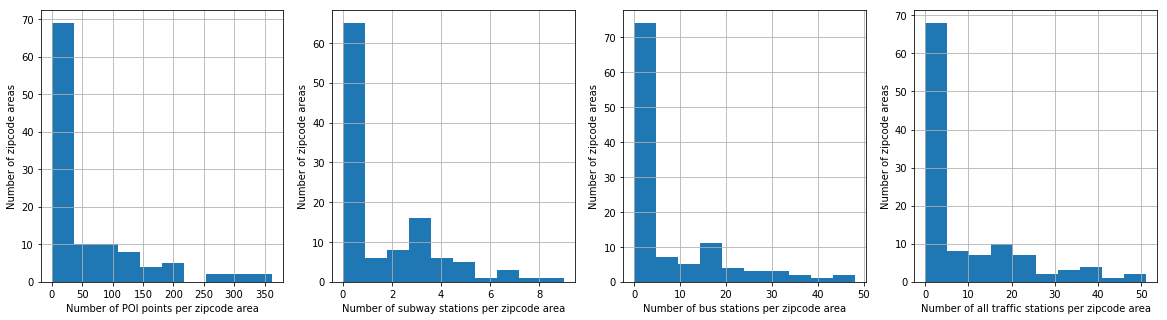

In [37]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(141)
zipcode.POI.hist(ax=ax)
ax.set_xlabel("Number of POI points per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(142)
zipcode.subway.hist(ax=ax)
ax.set_xlabel("Number of subway stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(143)
zipcode.bus.hist(ax=ax)
ax.set_xlabel("Number of bus stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(144)
zipcode.TrafficStation.hist(ax=ax)
ax.set_xlabel("Number of all traffic stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

**Figure 3-1** Distribution of 4 features (POI points number, subway station number, bus station number, and all traffic station number) by zipcode in Manhattan, NY. The distribution is dominated by very low number of zipcode areas.

(0, 18)

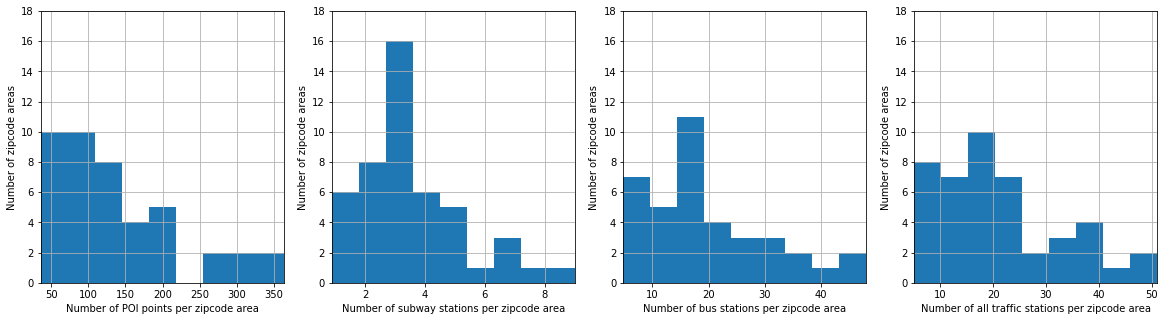

In [38]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(141)
plotdata = zipcode.POI
plotdata.hist(ax=ax)
ax.set_xlabel("Number of POI points per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,18)

ax = fig.add_subplot(142)
plotdata = zipcode.subway
plotdata.hist(ax=ax)
ax.set_xlabel("Number of subway stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,18)

ax = fig.add_subplot(143)
plotdata = zipcode.bus
plotdata.hist(ax=ax)
ax.set_xlabel("Number of bus stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,18)

ax = fig.add_subplot(144)
plotdata = zipcode.TrafficStation
plotdata.hist(ax=ax)
ax.set_xlabel("Number of all traffic stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,18)

**Figure 3-2** Distribution of 4 features (POI points number, subway station number, bus station number, and all traffic station number) by zipcode in Manhattan, NY, **extremely low values excluded**. They shows statistically consistent with Gaussians.

# 6. Measure correlation between Number of POI points and other 3 features (subway station number, bus station number, and all traffic station number)

Returns of pearsonr:(Pearson’s correlation coefficient, 2-tailed p-value)<br>
Do not use the p-value from the pearson's or Spearman's R unless under significant assumptins.<br>
refer to https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

In [39]:
sp.stats.pearsonr(zipcode.POI, zipcode.subway)

(0.64666902703955509, 1.3417641179601436e-14)

In [40]:
sp.stats.pearsonr(zipcode.POI, zipcode.bus)

(0.81737262302559033, 4.182858857344784e-28)

In [41]:
sp.stats.pearsonr(zipcode.POI, zipcode.TrafficStation)

(0.83970632932627975, 6.1106911723802141e-31)

**conclusions** there is a most statistical correlation between the number of POI points and all traffic station number: where the all traffic station number is higher the number of POI points are better, which is opposite to the null hypothesis.

# 7. Test if the average number of POI points is significantly different for zipcode areas with an all traffic station number grater than 25 and lower than 25.

## setting a significance threshold : alpha = 0.05

In [42]:
alpha = 0.05

## Null Hypothesis:
the null hypothesis is that the average number of POI points is the same at high all traffic station number ( > 25) and low all traffic station number (<= 25)<br>
all traffic station number come from the same parent distribution

### KS 
No need to standardize the distributions as I want to notice differences in the mean as well here!

In [43]:
p = sp.stats.ttest_ind(zipcode[zipcode.TrafficStation < 25]['POI'].values,
                   zipcode[zipcode.TrafficStation >= 25]['POI'].values)[1]
print("p=%d"%p)
if p > alpha:
    print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected")
else: 
    print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha)
    

p=0
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05


**conclusion ** The KS test reveals disparities in the average number of POI points with the all traffic station number

# 8. Colinearity of the average number of POI points and the all traffic station number

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [45]:
# modeling
y = zipcode.POI
x = zipcode.TrafficStation
x = sm.add_constant(x)
mod = smf.ols(formula='y ~ x', data=zipcode).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     263.0
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           6.11e-31
Time:                        18:14:35   Log-Likelihood:                -586.83
No. Observations:                 112   AIC:                             1178.
Df Residuals:                     110   BIC:                             1183.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.0145      2.622      1.531      0.129        -1.182     9.211
x[0]           4.0145      2.622      1.531      0.129        -1.182     9.211
x[1]           5.5869      0.344     16.218      0.000         4.904     6.270
==============================================================================
Omnibus:                       94.560   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.548
Skew:                           2.880   Prob(JB):                    7.16e-171
Kurtosis:                      14.607   Cond. No.                     4.94e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

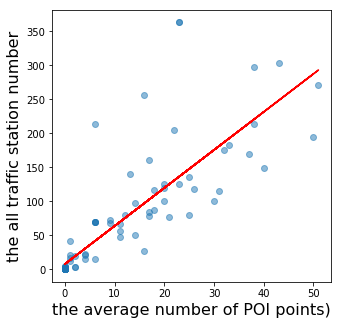

In [46]:
fig = pl.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_ylabel("the all traffic station number", fontsize =16)
ax.set_xlabel("the average number of POI points)", fontsize =16)

ax = plt.scatter(y=zipcode["POI"], x=zipcode["TrafficStation"], alpha=0.5)
ax = plt.plot(zipcode.TrafficStation, mod.fittedvalues, 'r')

**Figure 4** Scatter plot of the average number of POI points against the all traffic station number by zipcode area. Also plotted (red line) is a linear fit. 

# 9. Multivariate models

**Create a multivariate linear model with variables subway station number, bus station number, population, and area to study the most related factors to the number of POI points.** <br> 
Because all traffic stations include subway stations and bus stations, I don't use the number of all traffic station as one of the variables.

In [47]:
multimod = smf.ols(formula='POI ~ subway + bus + POPULATION + AREA',data=zipcode).fit()
multimod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    POI   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     106.4
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           2.27e-36
Time:                        18:14:36   Log-Likelihood:                -565.35
No. Observations:                 112   AIC:                             1141.
Df Residuals:                     107   BIC:                             1154.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.2784      4.574      0.717      0.475        -5.790    12.347
subway         0.9125      2.627      0.347      0.729        -4.295     6.120
bus            3.2159      0.762      4.219      0.000         1.705     4.727
POPULATION    -0.0005      0.000     -1.336      0.184        -0.001     0.000
AREA        6.287e-06   9.47e-07      6.636      0.000      4.41e-06  8.16e-06
==============================================================================
Omnibus:                       91.795   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.177
Skew:                           2.716   Prob(JB):                    5.88e-178
Kurtosis:                      15.057   Cond. No.                     1.26e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***
**Create a multivariate linear model with variables the number of all traffic station, population, and area to study the most related factors to the number of POI points.** <br> 

In [48]:
multimod = smf.ols(formula='POI ~ TrafficStation + POPULATION + AREA',data=zipcode).fit()
multimod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    POI   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     141.9
Date:                Wed, 12 Dec 2018   Prob (F-statistic):           2.54e-37
Time:                        18:14:36   Log-Likelihood:                -565.74
No. Observations:                 112   AIC:                             1139.
Df Residuals:                     108   BIC:                             1150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          2.4729      4.474      0.553      0.582        -6.396    11.341
TrafficStation     3.0977      0.749      4.135      0.000         1.613     4.583
POPULATION        -0.0004      0.000     -1.240      0.218        -0.001     0.000
AREA             5.91e-06   8.41e-07      7.025      0.000      4.24e-06  7.58e-06
==============================================================================
Omnibus:                       94.667   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              903.418
Skew:                           2.802   Prob(JB):                    6.69e-197
Kurtosis:                      15.735   Cond. No.                     1.22e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**In conclusion, the number of bus stations is the most correlated factor with the number of POI points.** <br>
Since area has an infinitesimally small correlation coefficient, there is no necessity to do further analysis the POI density (the number of POI points divide area) in Manhattan.

***

# 10. Overall Conclusions

** In conclusion, strong consistency and spatial correlation are shown between the traffic layout mode and the public service layout mode of Manhattan. The city central districts are common centre for the public service facilities and traffic stations. And they essentially have strong connection.**